# Project: Identify Customer Segments

In this project, I apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that I use has been provided by Bertelsmann Arvato Analytics.


In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [5]:
azdias.shape

(891221, 85)

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

In [6]:
# Identify missing or unknown data values and convert them to NaNs.
def define_missing(string):
    def_missing = string.replace('[', '').replace(']', '').split(',')

    if(def_missing != None):
        for i in range(len(def_missing)):
            try: def_missing[i] = int(def_missing[i])
            except ValueError: continue #we are trying to convert string to int ie int('XX') -> error  

    return def_missing

In [7]:
pd.value_counts(azdias.AGER_TYP)

-1    677503
 2     98472
 1     79802
 3     27104
 0      8340
Name: AGER_TYP, dtype: int64

In [8]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [9]:
#num previously missing values from whole df
print('total NaN: %s \n'%sum(azdias.isnull().sum()))
print('NaN per column\n %s'%azdias.isnull().sum().describe())

total NaN: 4896838 

NaN per column
 count        85.000000
mean      57609.858824
std       78323.462873
min           0.000000
25%           0.000000
50%       18348.000000
75%       98979.000000
max      584612.000000
dtype: float64


In [10]:
#Another way to do the above to replace all the missing or incomplete 
#in azdias with NaN based on the info in feat_info
for col in azdias:
    missing_rep = define_missing(feat_info[feat_info['attribute']==col]['missing_or_unknown'].values[0])
    
    if(missing_rep[0] == ''): 
        azdias[col] = azdias[col].replace('', np.nan)
        i+=1
        continue
    i=0
    replace_with = list(np.nan for i in missing_rep) #create list of None same length as missing_rep
    azdias[col] = azdias[col].replace(missing_rep, replace_with);

Another way to clean missing data
```python
# turn missing_or_unknown to list 
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))

# Identify missing or unknown data values and convert them to NaNs.
for attrib, missing_values in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
    if missing_values[0] != '':
        for value in missing_values:
            if value.isnumeric() or value.lstrip('-').isnumeric():
                value = int(value)
            azdias.loc[azdias[attrib] == value, attrib] = np.nan
```

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [11]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
null_count = np.asarray(azdias.isnull().sum().tolist())
print(null_count)

[685843   2881      0   4854      0      0      0      0      0      0
      0 392318   4854      0 111196  97632  94572  77792  77792   4854
   4854 108315 108164   4854      0      0      0      0      0      0
      0      0      0      0      0      0      0      0 111196  73499
 889061 111196      0 310267  73499  73499  18348 584612 147988  73499
  99611  97008  93148  73969  93148  93148  93148  99352  99352  99352
 133324 133324 133324 133324 476524 133324  93740  93740  93740  93155
 158064 133324   4854 158064 105800 116515 116515 116515 116515 116515
 116515 116515  97375  97274  97375]


In [12]:
# Investigate patterns in the amount of missing data in each column.
azdias.isnull().sum().describe()

count        85.000000
mean      98516.811765
std      146604.203317
min           0.000000
25%           0.000000
50%       93148.000000
75%      116515.000000
max      889061.000000
dtype: float64

In [13]:
#most common # of NaN: from `https://docs.python.org/2/library/collections.html#collections.Counter`
collections.Counter(null_count).most_common(12)

[(0, 24),
 (116515, 7),
 (4854, 6),
 (133324, 6),
 (73499, 4),
 (93148, 4),
 (111196, 3),
 (99352, 3),
 (93740, 3),
 (77792, 2),
 (158064, 2),
 (97375, 2)]

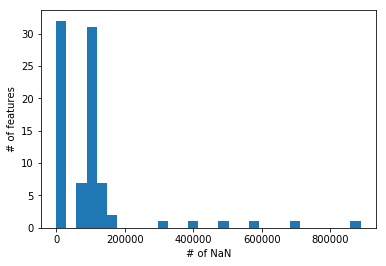

In [14]:
plt.hist(null_count, bins=30)
plt.xlabel("# of NaN")
plt.ylabel('# of features')
plt.show()

In [15]:
i_5, i_10, i_15, i_20 = 0,0,0,0
for value in null_count:
    if(value > 200000):
        i_20+=1
    elif(value > 150000):
        i_15 +=1
    elif(value>100000):
        i_10+=1
    elif(value>50000):
        i_5+=1

print('num null > 200,000: %s' % i_20, ' 200k-150k: %s'%i_15,' 150k-100k: %s'%i_10, ' 100k-50k: %s'%i_5)

num null > 200,000: 6  200k-150k: 2  150k-100k: 20  100k-50k: 25


In [16]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
labels_to_clean = []
for col in azdias:
    if(azdias[col].isnull().sum()>200000):
        labels_to_clean.append(col)
azdias_cleaned = azdias.drop(labels_to_clean, axis=1)

In [17]:
print(azdias_cleaned.shape)

for label in labels_to_clean:
    print(feat_info[feat_info['attribute'] == label][['attribute', 'information_level', 'type']])
    print('\n')

(891221, 79)
  attribute information_level         type
0  AGER_TYP            person  categorical


      attribute information_level     type
11  GEBURTSJAHR            person  numeric


   attribute information_level         type
40  TITEL_KZ            person  categorical


   attribute information_level      type
43  ALTER_HH         household  interval


       attribute information_level         type
47  KK_KUNDENTYP         household  categorical


       attribute information_level   type
64  KBA05_BAUMAX     microcell_rr3  mixed




#### Discussion 1.1.2: Assess Missing Data in Each Column

There were some columns with significant amounts of missing data. Out of the total of 891,221 observations, 6 of the features had more than 200,000 missing values. I decided that these were the outliers since close to 25% of the data was missing. Most of these were supposed to hold information on a personal or household level. Possibly people were uncomfortable disclosing this kind of information. The columns excluded from the dataset are shown above.

It is also interesting to note that many columns had identical numbers of missing values. The most common was 116515 missing values which occurred 7 time, including the following key/value paris of (#NaN,#occurences): `(4854, 6), (133324, 6), (73499, 4), (93148, 4), (111196, 3), (99352, 3), (93740, 3), (77792, 2), (158064, 2), (97375, 2)`. Since so many features had identical numbers of missing values it is most likely that it was the same entries (rows) that didn't fill in particular information (perhaps because it was sensitive). This might also mean that these columns contain similar data and it might not be necessary to keep all the features in this case.

For example, the 7 features that all have 116515 are all from the `PLZ8 macro_cell` features. This is all to do with information regarding the building types and family houses of the region a person lives in. Maybe all the people with mssing data live in the same region for which there is no data.

The features that each have 4845 missing values mostly come from different feature groupings/categories: `CJT_GESAMTTYP`, `GFK_URLAUBERTYP`, `RETOURTYP_BK_S`, `ONLINE_AFFINITAET`, apart from `LP_STATUS_FEIN` and `LP_STATUS_GROB` which are the same feature on a fine and rough scale. Since they are mostly different features describing different things maybe certain people here didn't feel comfortable disclosing this information.

This means that there are feasibly two reasons columns would have identical numer of NaN's:
1. they have similar meaning and if it is hard to get data on one then it is hard to get data for all features in that category (like `RR3 micro-cell`)

2. certain people didn't feel comfortable disclosing certain information and these people are likely to be more withdrawn in answering among various features.

#### Step 1.1.3: Assess Missing Data in Each Row

In [18]:
# How much data is missing in each row of the dataset?
azdias.isnull().sum(axis=1).describe() #count isnull along axis=1 --> along each row

count    891221.000000
mean          9.396018
std          13.971829
min           0.000000
25%           3.000000
50%           4.000000
75%           6.000000
max          54.000000
dtype: float64

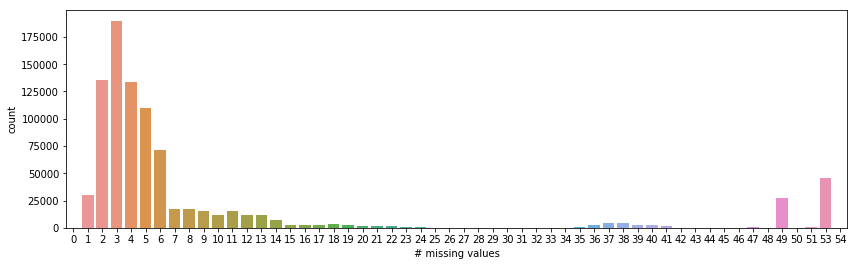

In [19]:
plt.figure(figsize=(14,4)) # this creates a figure 8 inch wide, 4 inch high
ax = sns.countplot(azdias.isnull().sum(axis=1))
ax.set_xlabel('# missing values')
plt.show()
##number of rows/data points that has x missing values

In [20]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_cleaned['num_null'] = azdias_cleaned.isnull().sum(axis=1)

In [21]:
#split into datum that have less than and more than 20 missing values
azdias_low = azdias_cleaned.query('num_null < 21').drop('num_null', axis=1)
azdias_high = azdias_cleaned.query('num_null > 20').drop('num_null', axis=1)
print(azdias_low.shape)
print(azdias_high.shape)

(797426, 79)
(93795, 79)


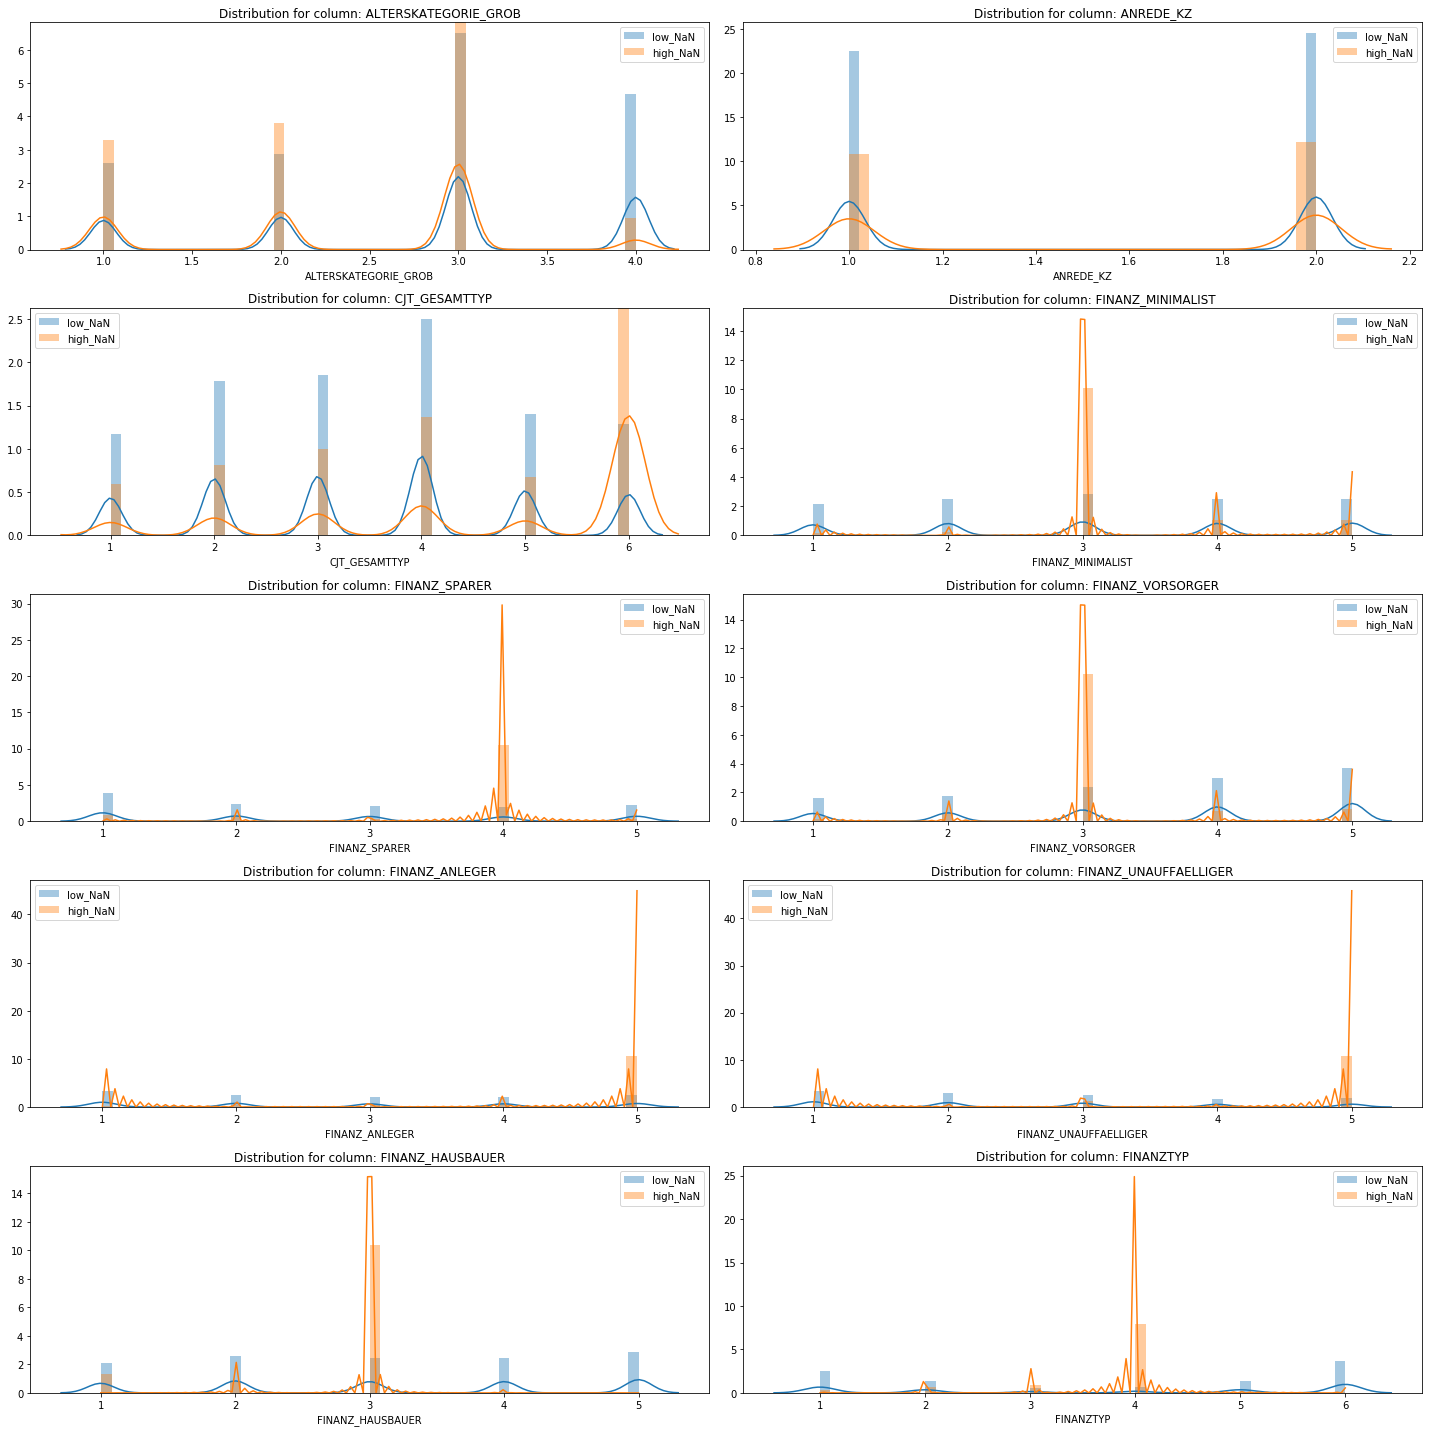

In [22]:
plt.figure(figsize=(20,20))
for i, col in enumerate(azdias_low.columns[:10]):
    plt.subplot(5, 2, i+1)
    sns.distplot(azdias_low[col][azdias_low[col].notnull()], label='low_NaN')
    sns.distplot(azdias_high[col][azdias_high[col].notnull()], label='high_NaN')
    plt.title('Distribution for column: {}'.format(col))
    plt.tight_layout()
    plt.legend();

In [23]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

#subplot params: num_rows, num_cols, which_subplot
def graph_value_dist(column):
    fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
    ax1.set_title('low NaN data')
    ax2.set_title('high NaN data')
    sns.countplot(azdias_low[column], ax=ax1)
    sns.countplot(azdias_high[column], ax=ax2)
    plt.show()

In [24]:
#get column names for distribution analysis
cols=[1,3,4,5,6,11]
col_names = []
for i in cols:
    null1 = azdias_low.iloc[:,i].isnull().sum()
    null2 = azdias_high.iloc[:,i].isnull().sum()
    col_name = azdias_low.iloc[:,i].name
    if(null1+null2 == 0):
        col_names.append(col_name)
        
print(col_names)

['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'GREEN_AVANTGARDE']


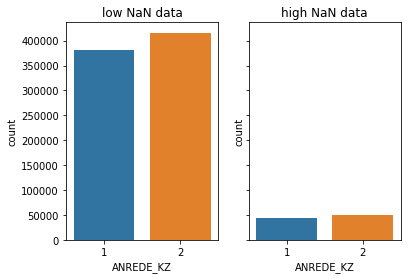

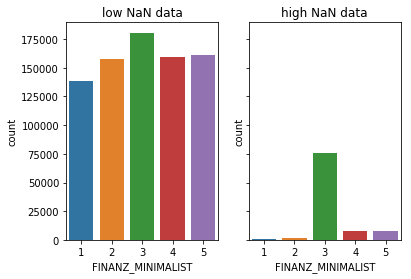

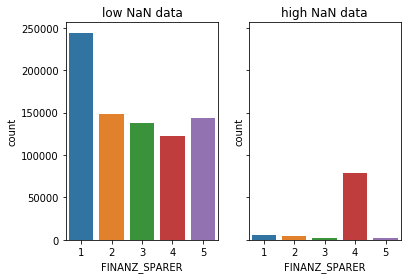

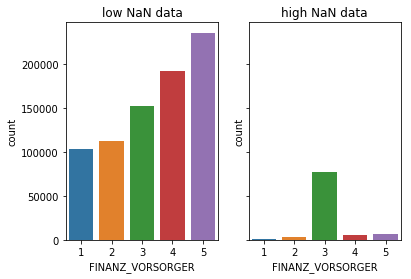

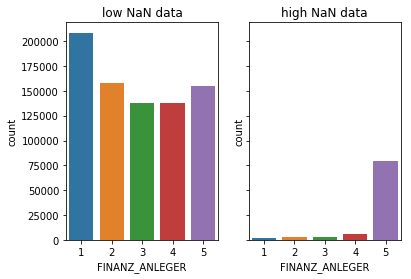

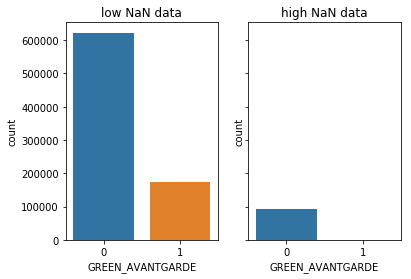

In [25]:
for col in col_names:
    graph_value_dist(col)

#### Discussion 1.1.3: Assess Missing Data in Each Row

I looked at 6 features where the data had no missing values, and quite interestingly some of these features had even distributions of values between the two datasets, and some were quite uneven. 

The highest difference in distributions was seen in the columns:
* FINANZ_ANLEGER
* FINANZ_SPARER
* FINANZ_VORSORGER

This means that 3 out of the 6 features I looked at have a very different distribution of values between the two splits of data- NaN heavy data and NaN light data.
This means that it might not be the best idea to drop a lot of the NaN datum, as it could disort the data. We should revist the high NaN rows later as some seem to be qualitatively different.

### Step 1.2: Select and Re-Encode Features

While almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In [26]:
# How many features are there of each data type?
#feat_info.groupby('type')['attribute'].nunique()
feat_info['type'].value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this, need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis.

In [27]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_vars = feat_info[feat_info['type'] == 'categorical']['attribute'].tolist()

for var in cat_vars:
    print(azdias[var].describe())
    print(azdias[var].isnull().sum())

count    205378.000000
mean          1.743410
std           0.674312
min           1.000000
25%           1.000000
50%           2.000000
75%           2.000000
max           3.000000
Name: AGER_TYP, dtype: float64
685843
count    891221.000000
mean          1.522098
std           0.499512
min           1.000000
25%           1.000000
50%           2.000000
75%           2.000000
max           2.000000
Name: ANREDE_KZ, dtype: float64
0
count    886367.000000
mean          3.632838
std           1.595021
min           1.000000
25%           2.000000
50%           4.000000
75%           5.000000
max           6.000000
Name: CJT_GESAMTTYP, dtype: float64
4854
count    891221.000000
mean          3.790586
std           1.987876
min           1.000000
25%           2.000000
50%           4.000000
75%           6.000000
max           6.000000
Name: FINANZTYP, dtype: float64
0
count    886367.000000
mean          7.350304
std           3.525723
min           1.000000
25%           5.000000
50

In [28]:
azdias['OST_WEST_KZ'].value_counts()

W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64

In [29]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_low['WEST_KZ'] = azdias_low['OST_WEST_KZ'].replace({'W':1, 'O':0})
azdias_low['WEST_KZ'].value_counts()

1    628987
0    168439
Name: WEST_KZ, dtype: int64

In [30]:
def imputer_freq(df, var): #fill in NaN with most common value in column
    most_freq = df[var].value_counts().idxmax()
    return df[var].fillna(most_freq)

In [31]:
one_hot_vars = ['CJT_GESAMTTYP', 'FINANZTYP','GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 
                'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 
                'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
for var in one_hot_vars:
    imputed_data = imputer_freq(azdias_low, var) #fill na-- imputation
    encode = pd.get_dummies(imputed_data, prefix=var) #one hot encode
    azdias_low = azdias_low.drop(var, axis=1) # remove column we onehot
    
    for col in encode.columns: #insert new encoded columns into the dataset
        azdias_low[col] = encode[col] 
        print(azdias_low.shape)

(797426, 80)
(797426, 81)
(797426, 82)
(797426, 83)
(797426, 84)
(797426, 85)
(797426, 85)
(797426, 86)
(797426, 87)
(797426, 88)
(797426, 89)
(797426, 90)
(797426, 90)
(797426, 91)
(797426, 92)
(797426, 93)
(797426, 94)
(797426, 95)
(797426, 96)
(797426, 97)
(797426, 98)
(797426, 99)
(797426, 100)
(797426, 101)
(797426, 101)
(797426, 102)
(797426, 103)
(797426, 104)
(797426, 105)
(797426, 106)
(797426, 107)
(797426, 108)
(797426, 109)
(797426, 110)
(797426, 111)
(797426, 111)
(797426, 112)
(797426, 113)
(797426, 114)
(797426, 115)
(797426, 115)
(797426, 116)
(797426, 117)
(797426, 118)
(797426, 119)
(797426, 120)
(797426, 121)
(797426, 122)
(797426, 123)
(797426, 124)
(797426, 124)
(797426, 125)
(797426, 126)
(797426, 127)
(797426, 128)
(797426, 128)
(797426, 129)
(797426, 130)
(797426, 130)
(797426, 131)
(797426, 132)
(797426, 133)
(797426, 133)
(797426, 134)
(797426, 135)
(797426, 136)
(797426, 137)
(797426, 138)
(797426, 138)
(797426, 139)
(797426, 140)
(797426, 141)
(797426, 142)


In [32]:
drop_categorical = ['KK_KUNDENTYP', 'TITEL_KZ', 'AGER_TYP']
for category in drop_categorical:
    try: azdias_low = azdias_low.drop(category, axis=1)
    except ValueError: print('{0} already cleaned from dataset'.format(category))

KK_KUNDENTYP already cleaned from dataset
TITEL_KZ already cleaned from dataset
AGER_TYP already cleaned from dataset


#### Discussion 1.2.1: Re-Encode Categorical Features

* The non-numerical binary variable is: `OST_WEST_KZ`
* `CAMEO_DEU_2015` and `CAMEO_DEUG_2015` is a multi-level categorical: alphanumeric
* `SOHO_KZ` and `GREEN_AVANTGARDE` is a regular binary variable
    * `ANREDE_KZ` is binary, but takes values `[1,2]`

The variables that need to be re-encoded are:
* non-numerical binary var: `OST_WEST_KZ` will be converted to regular binary
* all multi-level categoricals will be one hot encoded

The variables I dropped are:
* `KK_KUNDENTYP`
* `TITEL_KZ`
* `AGER_TYP`

I dropped them because they had very few (relative to length of dataset) non-missing values. Which wouldn't be useful for analysis anyway.

##### Engineering Steps
For alphanumeric binary var `OST_WEST_KZ`:

 * converted `OST_WEST_KZ` to binary variable: `WEST_KZ`
     * `W` maps to `1` (signifies True/1 for "west")
     * `O` maps to `0`

-------
For categorical variables: `['CJT_GESAMTTYP', 'FINANZTYP','GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']`
1. First, I imputed each variable column to prevent getting a one hot encoded column for NaN - missing values.
    * to do this I find the highest frequency value in each common (most likely category), and then fill the missing values with that instead of a mean for example. The mean would be a bad choice to impute categorical variables as it makes the variable continuous rather than discrete.
    
2. Secondly, I used pandas.get_dummies to one hot encode each column, dropped the original column from the dataset, and then added the new encoded data columns to the dataset.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [33]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
print(azdias['PRAEGENDE_JUGENDJAHRE'].value_counts())
decade_mapping = {1:40, 2:40,3:50,4:50,5:60,6:60,7:60,8:70,9:70,10:80,11:80,12:80,13:80,14:90,15:90}
avantgarde_mapping ={1:0,2:1,3:0,4:1,5:0,6:1,7:1,8:0,9:1,10:0,11:1,12:0,13:1,14:0,15:1}

azdias_low['AVANTGARDE'] = azdias_low['PRAEGENDE_JUGENDJAHRE'].map(avantgarde_mapping)
azdias_low['YOUTH_DECADE'] = azdias_low['PRAEGENDE_JUGENDJAHRE'].map(decade_mapping)

#impute null values
azdias_low['AVANTGARDE'] = imputer_freq(azdias_low, 'AVANTGARDE')
azdias_low['YOUTH_DECADE'] = imputer_freq(azdias_low, 'YOUTH_DECADE')

14.0    188697
8.0     145988
5.0      86416
10.0     85808
3.0      55195
15.0     42547
11.0     35752
9.0      33570
6.0      25652
12.0     24446
1.0      21282
4.0      20451
2.0       7479
13.0      5764
7.0       4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64


In [34]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
print('number of nulls: %s'%azdias_low['CAMEO_INTL_2015'].isnull().sum())
print('value counts: %s' % azdias_low['CAMEO_INTL_2015'].value_counts())

number of nulls: 6003
value counts: 51    133673
41     92309
24     91099
14     62851
43     56653
54     45376
25     39605
22     33137
23     26667
13     26311
45     26126
55     23939
52     20538
31     18979
34     18517
15     16966
44     14817
12     13234
35     10352
32     10346
33      9928
Name: CAMEO_INTL_2015, dtype: int64


In [35]:
def decode_wealth(key):
    if(len(str(key))==2):
        tens = int(str(key)[0])
        return tens
    else: return np.nan
    
def decode_life(key):
    if(len(str(key))==2):
        ones = int(str(key)[1])
        return ones
    else: return np.nan

In [36]:
'''ENGINEERING OF `CAMEO_INTL_2015` '''
azdias_low['CAMEO_INTL_2015_WEALTH'] = azdias_low['CAMEO_INTL_2015'].apply(decode_wealth)
azdias_low['CAMEO_INTL_2015_LIFE'] = azdias_low['CAMEO_INTL_2015'].apply(decode_life)

#impute nan values
azdias_low['CAMEO_INTL_2015_WEALTH'] = imputer_freq(azdias_low, 'CAMEO_INTL_2015_WEALTH')
azdias_low['CAMEO_INTL_2015_LIFE'] = imputer_freq(azdias_low, 'CAMEO_INTL_2015_LIFE')

In [37]:
mixed_feat = feat_info[feat_info['type'] == 'mixed']['attribute'].tolist()
mixed_feat.remove('PRAEGENDE_JUGENDJAHRE')
mixed_feat.remove('CAMEO_INTL_2015')
print(mixed_feat)

['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'KBA05_BAUMAX', 'PLZ8_BAUMAX']


In [38]:
#INVESTIGATE REMAINING MIXED-VARS
for feat in mixed_feat:
    try: print('{0} has {1} null values'.format(feat, azdias_low[feat].isnull().sum()))
    except KeyError: mixed_feat.remove(feat);

LP_LEBENSPHASE_FEIN has 49651 null values
LP_LEBENSPHASE_GROB has 46830 null values
WOHNLAGE has 0 null values


In [39]:
for feat in mixed_feat:
    print('{0} has {1} null values'.format(feat, azdias_low[feat].value_counts()))

LP_LEBENSPHASE_FEIN has 1.0     58722
5.0     52400
6.0     43334
2.0     37148
8.0     28837
11.0    25369
7.0     24950
29.0    24880
13.0    24811
10.0    24469
12.0    22275
31.0    22261
30.0    21147
15.0    18966
3.0     18756
19.0    18586
37.0    17500
4.0     16478
14.0    16354
20.0    16287
32.0    15763
39.0    15132
40.0    14108
27.0    13800
16.0    13633
38.0    13099
35.0    13011
34.0    12422
9.0     12111
21.0    11966
28.0    11543
24.0    11309
25.0     9849
36.0     9656
23.0     8628
22.0     6831
18.0     6805
33.0     5724
17.0     5487
26.0     3368
Name: LP_LEBENSPHASE_FEIN, dtype: int64 null values
LP_LEBENSPHASE_GROB has 2.0     149521
1.0     131104
3.0     109623
12.0     69495
4.0      51186
5.0      47165
9.0      46027
10.0     38024
11.0     31157
8.0      28711
6.0      27425
7.0      21158
Name: LP_LEBENSPHASE_GROB, dtype: int64 null values
WOHNLAGE has 3.0    249592
7.0    169269
4.0    135906
2.0    100328
5.0     74305
1.0     43891
8.0     173

In [40]:
rural_map={1:0,2:0,3:0,4:0,5:0,7:1,8:1}
azdias_low['RURAL'] = azdias_low['WOHNLAGE'].map(rural_map)
azdias_high['RURAL'] = azdias_high['WOHNLAGE'].map(rural_map)

#### Discussion 1.2.2: Engineer Mixed-Type Features

-------
###### Engineering  `PRAEGENDE_JUGENDJAHRE`
1. created mapping from the current variable to a categorical `YOUTH_DECADE` variable
    * denotes which decade the persons childhood was in. for example 60s became `60`
2. created mapping from the current variable to a binary `AVANTGARDE` variable
    * if the predominant movement during this persons childhood was avantgarde, the binary var denotes `1.0` otherwise it denotes `0.0`

-------
###### Engineering  `CAMEO_INTL_2015`
1. first defined two mapping functions: `decode_wealth` and `decode_life`
    * `decode_wealth` returns the first digit of the orginial variable which shows wealth status
    * `decode_life` returns the second digit of the original variable showing life stage
    
2. I applied this function to the data set and created a new ordinal variable for each wealth and life stage
   * `CAMEO_INTL_2015_WEALTH`
   * `CAMEO_INTL_2015_LIFE`
    
###### Other mixed variables
the remaining mixed variables that were still in data set after engineering step were:
`['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE','PLZ8_BAUMAX']`

* `LP_LEBENSPHASE_FEIN`
    * this variable essentially encodes the same things as `CAMEO_INTL_2015`, so I decided to drop it

* `LP_LEBENSPHASE_GROB`
    * this variable is the same as the variable above but on rougher scale, dropping as well
    
* `WOHNLAGE`
    * `CAMEO_DEU_2015` contains similar but more defined information. `WOHNLAGE` is encoded as 1: rural, 0: not-rural

* `PLZ8_BAUMAX`
    * this variable is encapsulated by the information in other `PLZ8` variables, is dropped.

#### Step 1.2.3: Complete Feature Selection

The dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

*NB* data should only be from **the subset with few or no missing values**.

--------
Some variables have been dropped already. Below, I will go through all features that have been encoded or need to be dropped again to double check

In [41]:
#double check that features have been dropped
one_hot_vars = ['CJT_GESAMTTYP', 'FINANZTYP','GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 
                'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 
                'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
drop_categorical = ['KK_KUNDENTYP', 'TITEL_KZ', 'AGER_TYP',
                       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'KBA05_BAUMAX','PLZ8_BAUMAX'] #high error categoricals

mixed_cat = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']
for feature in one_hot_vars+drop_categorical+mixed_cat + ['OST_WEST_KZ']:
    if feature in azdias_low.columns:
        print('cleaning {0}:'.format(feature))
        azdias_low = azdias_low.drop(feature, axis=1)

cleaning LP_LEBENSPHASE_FEIN:
cleaning LP_LEBENSPHASE_GROB:
cleaning WOHNLAGE:
cleaning PLZ8_BAUMAX:
cleaning PRAEGENDE_JUGENDJAHRE:
cleaning CAMEO_INTL_2015:
cleaning OST_WEST_KZ:


### Step 1.3: Create a Cleaning Function

In [42]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    '''all main cleaning steps:'''
    # convert missing value codes into NaNs, ...
    for col in df:
        missing_rep = define_missing(feat_info[feat_info['attribute']==col]['missing_or_unknown'].values[0])
        if(missing_rep[0] == ''): 
            df[col] = df[col].replace('', np.nan)
        else:
            replace_with = [np.nan for i in missing_rep] #create list of None same length as missing_rep
            df[col] = df[col].replace(missing_rep, replace_with)
    # remove selected columns and rows, ...
    features_to_clean = ['AGER_TYP','GEBURTSJAHR','TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
                         'KBA05_BAUMAX']
    
    df = df.drop(features_to_clean, axis=1)
    df['num_null'] = df.isnull().sum(axis=1) #count null for each row
    
    #keep only low missing value rows
    df = df.query('num_null < 21').drop('num_null', axis=1)
    
    # select, re-encode, and engineer column values.
    cat_vars = feat_info[feat_info['type'] == 'categorical']['attribute'].tolist()
    mixed_vars = feat_info[feat_info['type'] == 'mixed']['attribute'].tolist()
    
    #re-encode binary var
    df['WEST_KZ'] = df['OST_WEST_KZ'].replace({'W':1, 'O':0})
    
    #one hot encode
    one_hot_vars = ['CJT_GESAMTTYP', 'FINANZTYP','GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 
                'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 
                'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
    
    for var in one_hot_vars:
        imputed_data = imputer_freq(df, var) #fill na-- imputation
        encode = pd.get_dummies(imputed_data, prefix=var) #one hot encode

        for col in encode.columns: #insert new encoded columns into the dataset
            df[col] = encode[col] 
            
    #engineer mixed vars
    decade_mapping = {1:40, 2:40,3:50,4:50,5:60,6:60,7:60,8:70,
                      9:70,10:80,11:80,12:80,13:80,14:90,15:90}
    avantgarde_mapping ={1:0,2:1,3:0,4:1,5:0,6:1,7:1,8:0,
                         9:1,10:0,11:1,12:0,13:1,14:0,15:1}
    
    rural_mapping = {1:0,2:0,3:0,4:0,5:0,7:1,8:1}
        #map variables
    df['RURAL'] = df['WOHNLAGE'].map(rural_mapping)
    df['AVANTGARDE'] = df['PRAEGENDE_JUGENDJAHRE'].map(avantgarde_mapping)
    df['YOUTH_DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_mapping)
    
    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].apply(decode_wealth)
    df['CAMEO_INTL_2015_LIFE'] = df['CAMEO_INTL_2015'].apply(decode_life)
    
    #remove all features either re-encoded, or not needed for analysis
    drop_categorical = ['KK_KUNDENTYP', 'TITEL_KZ', 'AGER_TYP',
                       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
                        'WOHNLAGE', 'KBA05_BAUMAX','PLZ8_BAUMAX'] #high error categoricals
    
    shape_before = df.shape[1]
    mixed_cat = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']
    to_drop = one_hot_vars+drop_categorical+mixed_cat+['OST_WEST_KZ']

    #already removed in high NaN column cleaning, make sure we dont try to drop again
    for removed in ['AGER_TYP','GEBURTSJAHR','TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
                         'KBA05_BAUMAX']:
        if removed in to_drop:
            to_drop.remove(removed)
    
    df = df.drop(to_drop, axis=1) 

    # Return the cleaned dataframe.
    
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. 
- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1. (RobustScaler also ok)
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [43]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
azdias_low.isnull().sum(axis=0).describe()

count      193.000000
mean      3573.564767
std      11363.386643
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      64433.000000
dtype: float64

In [44]:
feat_info['type'].value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

In [45]:
#impute all variables using mode since many are categorical or binary, very few purely continuous vars
#highest missing value is 38,000 which is still only about 5.5% of values
imputer = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
azdias_imputed = pd.DataFrame(imputer.fit_transform(azdias_low),
                              index=azdias_low.index, columns=azdias_low.columns)

#end result is new imputed DF

In [46]:
azdias_imputed.isnull().sum(axis=1).describe()
#check that no more null

count    797426.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
dtype: float64

In [47]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()

azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_imputed),
                              index=azdias_imputed.index, columns=azdias_imputed.columns)

In [48]:
azdias_scaled.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,AVANTGARDE,YOUTH_DECADE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE,RURAL
count,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,...,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05
mean,8.509483e-17,8.277811e-17,1.346548e-16,-8.425725e-17,-3.776250e-17,-9.630418e-17,1.835286e-16,-8.126334e-17,-1.561111e-17,-8.625319e-17,...,-2.060988e-17,3.715659e-18,-1.407852e-18,1.045464e-16,5.556559e-17,-1.561111e-17,-3.827753e-16,4.856197e-17,4.130886e-17,3.727688e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.766334e+00,-1.043765e+00,-1.494609e+00,-1.155304e+00,-1.766955e+00,-1.249881e+00,-1.184467e+00,-1.502317e+00,-5.305674e-01,-1.633717e+00,...,-1.625923e-01,-1.895778e-01,-1.798523e-01,-1.928439e-01,-8.974298e-02,-5.305674e-01,-2.316187e+00,-1.551476e+00,-1.249157e+00,-5.528315e-01
25%,-7.828722e-01,-1.043765e+00,-7.686897e-01,-1.155304e+00,-1.040726e+00,-1.249881e+00,-1.184467e+00,-7.920337e-01,-5.305674e-01,-3.116745e-01,...,-1.625923e-01,-1.895778e-01,-1.798523e-01,-1.928439e-01,-8.974298e-02,-5.305674e-01,-9.502996e-01,-8.696736e-01,-1.249157e+00,-5.528315e-01
50%,2.005893e-01,9.580705e-01,-4.276997e-02,1.914482e-01,4.117312e-01,1.082835e-01,-4.697522e-01,-8.175029e-02,-5.305674e-01,-3.116745e-01,...,-1.625923e-01,-1.895778e-01,-1.798523e-01,-1.928439e-01,-8.974298e-02,-5.305674e-01,4.155877e-01,4.939317e-01,9.484474e-02,-5.528315e-01
75%,1.184051e+00,9.580705e-01,6.831497e-01,8.648242e-01,1.137960e+00,7.873659e-01,9.596769e-01,6.285331e-01,-5.305674e-01,1.010368e+00,...,-1.625923e-01,-1.895778e-01,-1.798523e-01,-1.928439e-01,-8.974298e-02,-5.305674e-01,1.098531e+00,1.175734e+00,7.668454e-01,-5.528315e-01
max,1.184051e+00,9.580705e-01,1.409069e+00,1.538200e+00,1.137960e+00,1.466448e+00,1.674391e+00,1.338816e+00,1.884775e+00,1.010368e+00,...,6.150354e+00,5.274880e+00,5.560118e+00,5.185540e+00,1.114293e+01,1.884775e+00,1.098531e+00,1.175734e+00,1.438846e+00,1.808870e+00


### Discussion 2.1: Apply Feature Scaling

1. I first had to make sure that there were no null values in the data set. Most of the data had very few nulls left. Only two features had more than 20,000 NaN, which is only about 5% of all the values.
    * I decided that the best imputation method was mode instead of mean. Most of the values are categorical, and even some of the numeric values like birth year wouldnt make sense if they were continuous. Therefore, I imputed using most_frequent
    
2. I used the StandardScaler() provided by sklearn.preprocessing to scale all the values to mean 0 and stdDev = 1. This was suggested in the writeup.

### Step 2.2: Perform Dimensionality Reduction

Apply PCA on scaled data
- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [49]:
# Apply PCA to the data.
pca = PCA()
pca_fit = pca.fit(azdias_scaled)

In [50]:
def scree_plot(pca): ##code from helper_functions.py in PCA lesson
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    RETURN: None
    '''
    num_components= len(pca.explained_variance_ratio_)
    idx = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(15, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(idx, vals)
    ax.plot(idx, cumvals)
    for i in range(num_components):
        if(i%20 == 0 or i<6):
            ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (idx[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=8)
 
    ax.xaxis.set_tick_params(width=0, gridOn=True)
    ax.yaxis.set_tick_params(width=2, length=12, gridOn=True)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

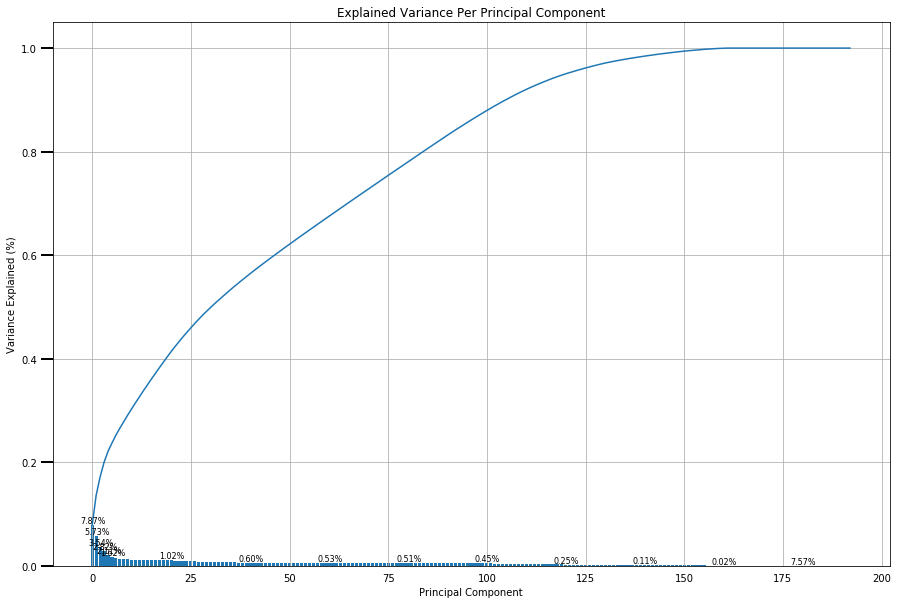

In [51]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca_fit)

In [65]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=75)
pca.fit(azdias_scaled)
pca_data = pca.transform(azdias_scaled)

In [63]:
pca_data.shape

(797426, 75)

### Discussion 2.2: Perform Dimensionality Reduction

The Principal Component Analysis with all of the Principal Components showed that the first 6 Principal Components each explain more than 3% of the total variance, with the highest explained variance for a single Principal Component being ~8%. The first 15 Principal Components explain 40% of all the variance. I am retaining 75 of the 185 Prinicpal Components for the analysis, as they explain about 75% of the total variance.

It is interesting to note that the last 50 components (#125-175) explain very little of the variance.

### Step 2.3: Interpret Principal Components

- To investigate the features, map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- Investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [64]:
def investigate_PC(pca, component, feature_names):
    #code inspired by helper_functions.py in PCA lesson
    '''
    Prints association of a feature to the weights of its components
    INPUT: pca: PCA object, compnent: which component is to be investigated (0 indexed),
            feature_names: the corresponding feature names to PCA
    OUTPUT: None
    '''
    
    num_out = 10
    
    if(component <= len(pca.components_)):
        pca_feature_map = pd.DataFrame({'weight': pca.components_[component],
                                        'name': feature_names})
        
        pca_feature_map = pca_feature_map.sort_values(by='weight', ascending=False)
        
        print('Principal Component {}\n---------------\n'.format(component+1))
        print('TOP {0} PRINCIPAL COMPONENTS \n {1}'.format(num_out, pca_feature_map.iloc[:num_out,:]))
        print('\n BOTTOM {0} PRINCIPAL COMPONENTS \n {1}'.format(num_out, pca_feature_map.iloc[-num_out:,:]))
            
    else:
        print('Error in selecting component')
    

In [65]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
investigate_PC(pca, 0, azdias_scaled.columns)

Principal Component 1
---------------

TOP 10 PRINCIPAL COMPONENTS 
                        name    weight
110      LP_STATUS_GROB_1.0  0.196198
29       HH_EINKOMMEN_SCORE  0.184257
190  CAMEO_INTL_2015_WEALTH  0.184198
52               PLZ8_ANTG3  0.182683
53               PLZ8_ANTG4  0.175970
57              ORTSGR_KLS9  0.158971
42                 EWDICHTE  0.156777
7          FINANZ_HAUSBAUER  0.147975
39              KBA05_ANTG4  0.129277
100      LP_STATUS_FEIN_1.0  0.126992

 BOTTOM 10 PRINCIPAL COMPONENTS 
                    name    weight
113  LP_STATUS_GROB_4.0 -0.112923
192               RURAL -0.115940
43           INNENSTADT -0.129658
55             PLZ8_GBZ -0.132682
34          KONSUMNAEHE -0.137710
36          KBA05_ANTG1 -0.180067
40            KBA05_GBZ -0.181211
50           PLZ8_ANTG1 -0.183000
46           MOBI_REGIO -0.187957
2     FINANZ_MINIMALIST -0.191273


In [66]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
investigate_PC(pca, 1, azdias_scaled.columns)

Principal Component 2
---------------

TOP 10 PRINCIPAL COMPONENTS 
                      name    weight
0    ALTERSKATEGORIE_GROB  0.232889
4        FINANZ_VORSORGER  0.218994
124            ZABEOTYP_3  0.199978
17              SEMIO_ERL  0.180259
16             SEMIO_LUST  0.163505
10         RETOURTYP_BK_S  0.155426
30         W_KEIT_KIND_HH  0.123088
61      CJT_GESAMTTYP_2.0  0.108279
70            FINANZTYP_5  0.098996
100    LP_STATUS_FEIN_1.0  0.097016

 BOTTOM 10 PRINCIPAL COMPONENTS 
                       name    weight
47       ONLINE_AFFINITAET -0.161964
18              SEMIO_KULT -0.165087
19               SEMIO_RAT -0.168245
5           FINANZ_ANLEGER -0.204721
23           SEMIO_PFLICHT -0.205375
24             SEMIO_TRADV -0.208003
13               SEMIO_REL -0.214557
6    FINANZ_UNAUFFAELLIGER -0.214972
3            FINANZ_SPARER -0.227059
189           YOUTH_DECADE -0.230622


In [67]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
investigate_PC(pca, 2, azdias_scaled.columns)

Principal Component 3
---------------

TOP 10 PRINCIPAL COMPONENTS 
                   name    weight
15          SEMIO_VERT  0.316899
12           SEMIO_FAM  0.258536
11           SEMIO_SOZ  0.255493
18          SEMIO_KULT  0.249721
70         FINANZTYP_5  0.137373
2    FINANZ_MINIMALIST  0.130359
118    SHOPPER_TYP_0.0  0.122717
122         ZABEOTYP_1  0.119285
13           SEMIO_REL  0.113028
14           SEMIO_MAT  0.088319

 BOTTOM 10 PRINCIPAL COMPONENTS 
                    name    weight
101  LP_STATUS_FEIN_2.0 -0.079073
120     SHOPPER_TYP_2.0 -0.092057
66          FINANZTYP_1 -0.099714
19            SEMIO_RAT -0.152760
5        FINANZ_ANLEGER -0.155240
17            SEMIO_ERL -0.207281
20           SEMIO_KRIT -0.266130
21            SEMIO_DOM -0.279330
22           SEMIO_KAEM -0.311478
1             ANREDE_KZ -0.342268


### Discussion 2.3: Interpret Principal Components

*Each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.*

##### 1st Principal Component
The first principal component is explained mostly by the `LP_STATUS_GROB_1.0` variable which shows the social status: *low-income earner* of a specific person. The next three features with highest weight: `HH_EINKOMMEN_SCORE`, `CAMEO_INTL_2015_WEALTH`, `PLZ8_ANTG3`, are all also a certain measure of wealth or income. We can reconcile this with the fact that features with large weights in the same sign are a sign of correlation between the variables. Realistically, we would expect that each feature portraying wealth would be correlated.
The three most negatively correlated features are: `FINANZ_MINIMALIST`,`KBA05_ANTG1`, `MOBI_REGIO`. For example: `FINANZ_MINIMALIST`, shows the lack of interest of someone in finance, which has an obvious negative correlation to wealth.

##### 2nd Principal Component
The second principal component is explained mostly by: `ALTERSKATEGORIE_GROB`,  `FINANZ_VORSORGER`, `ZABEOTYP_3`, and the least by: `YOUTH_DECADE`, `FINANZ_SPARER`, `SEMIO_REL`. This is a mixture of age, financial awareness, and environmental/religious awareness respectively. 

##### 3rd Principal Component
I find this third component most interesting, as many of the features that explain this principal component relate to personality traits. The most explanatory feature is `SEMIO_VERT` which is a measure of 'dreamfulness', followed by `SEMIO_FAM`: family-mindedness, `SEMIO_SOZ`: socially-mindedness and so forth. The least explanatory features, and those most negatively correlated are interestingly: `ANREDE_KZ` which shows gender, `SEMIO_KAEM` which is a combative-minded feature, `SEMIO_DOM` which is a dominant-minded feature and so forth.

------
What is interesting is that as we move through the principal components, at least the first three, the weights on features become larger. This means that those features more strongly explain the principal component, after accounting for the variance captured by earlier principal components.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

I've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

In [69]:
model_score=[]
clusters = [2,4,6,8,10,12,14,16,18,20]
# Over a number of different cluster counts...
for i in clusters:
    # run k-means clustering on the data and...
    kmeans = KMeans(i).fit(pca_data)
    
    # compute the average within-cluster distances.
    model_score.append(abs(kmeans.score(pca_data)))
    

Could also use `Silhouette Coefficient` to analyze number of clusters: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

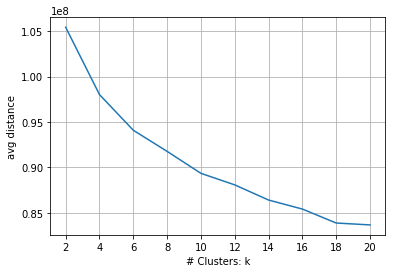

In [101]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
fig, ax = plt.subplots()
ax.plot(clusters, model_score)
ax.set(ylabel='avg distance', xlabel='# Clusters: k')
ax.grid()
plt.xticks(np.arange(2,21,2))
plt.show()

In [71]:
pca_data.shape

(797426, 75)

In [66]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(10).fit(pca_data)
kmeans_pred = kmeans.predict(pca_data)

### Discussion 3.1: Apply Clustering to General Population

When investigating clustering and drawing scree-plot, I did not find a specific kink in the graph, but rather the average distance kept decreasing. The largest decrease happened in the first 5 clusters, before the benefit of adding an extra cluster starts levelling out. This is why I chose to segment the population into 10 clusters, a nice round number where the average distance is starting to level out on the scree plot.

### Step 3.2: Apply All Steps to the Customer Data

Now that I have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, I interpret how the general population fits apply to the customer data.

In [73]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [74]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_cleaned = clean_data(customers)

In [77]:
for column in azdias_scaled.columns:
    if column not in customers_cleaned.columns:
        print(column)

GEBAEUDETYP_5.0


In [78]:
customers_cleaned['GEBAEUDETYP_5.0'] = 0
#this column was missing from customer dataset after one-hot encoding

In [79]:
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [80]:
customer_reduced = pca.transform(scaler.transform(imputer.transform(customers_cleaned)))

customer_clusters = kmeans.predict(customer_reduced)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, I have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, I compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

In [81]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
gen_pop = azdias_scaled.shape[0]
gen_pop_all = azdias.shape[0] #including all dropped high NaN data

customer_pop = customers_cleaned.shape[0]
customer_pop_all = customers.shape[0] #including all customers with high NaN data

gen_pop_cluster_count = np.bincount(kmeans_pred)
customer_cluster_count = np.bincount(customer_clusters)

gen_pop_cluster_prop = [x/gen_pop for x in gen_pop_cluster_count]
customer_cluster_prop = [x/customer_pop for x in customer_cluster_count]

In [82]:
prop_data = pd.DataFrame({'gen_pop': gen_pop_cluster_prop, 'customers': customer_cluster_prop}, index=np.arange(1,11))
prop_data.index.names=['Cluster']

In [83]:
#create data frame where each entry in `gen_pop` is % of gen_pop in a cluster
# each entry in `customers` is% of customer population in a cluster
prop_data_all = pd.DataFrame({'gen_pop': [x/gen_pop_all for x in gen_pop_cluster_count], 
                              'customers': [x/customer_pop_all for x in customer_cluster_count]},
                             index=np.arange(1,11))
prop_data_all.index.names=['Cluster']

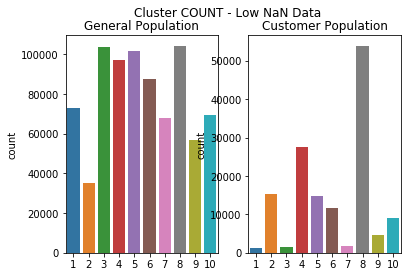

In [107]:
'''CLUSTER COUNT - LOW NAN DATA'''

plt.figure(figsize=(10,5)) # this creates a figure 14 inch wide, 4 inch high
fig, (ax1, ax2) = plt.subplots(1,2, sharey=False)
fig.suptitle('Cluster COUNT - Low NaN Data')
ax1.set_title('General Population')
ax2.set_title('Customer Population')
sns.countplot(kmeans_pred+1, ax=ax1)
sns.countplot(customer_clusters+1, ax=ax2)
plt.show()

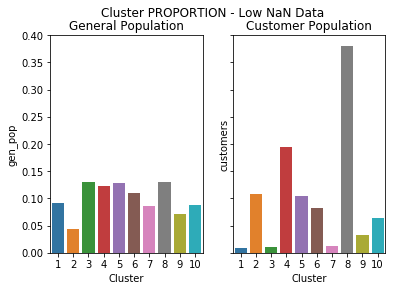

In [106]:
'''CLUSTER PROPORTION - LOW NAN DATA'''

plt.figure(figsize=(14,4)) # this creates a figure 14 inch wide, 4 inch high
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
fig.suptitle('Cluster PROPORTION - Low NaN Data')
ax1.set_title('General Population')
ax2.set_title('Customer Population')
sns.barplot(x=prop_data.index, y=prop_data.gen_pop, ax=ax1)
sns.barplot(x=prop_data.index, y=prop_data.customers, ax=ax2)
plt.show()

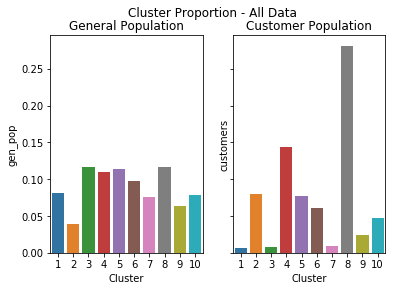

In [86]:
'''CLUSTER PROPORTION - ALL DATA'''

plt.figure(figsize=(14,4)) # this creates a figure 14 inch wide, 4 inch high
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
fig.suptitle('Cluster Proportion - All Data')
ax1.set_title('General Population')
ax2.set_title('Customer Population')
sns.barplot(x=prop_data_all.index, y=prop_data_all.gen_pop, ax=ax1)
sns.barplot(x=prop_data_all.index, y=prop_data_all.customers, ax=ax2)
plt.show()

In [89]:
''' What kinds of people are part of a cluster that is overrepresented 
in the customer data compared to the general population?'''

rep = {}

print('\n Cluster Representation - LOW NaN Data\n----------\n')
for i in np.arange(0,10):
    a = customer_cluster_prop[i]
    b = gen_pop_cluster_prop[i]
    rep[i+1] = (a-b)*100

for x in rep:
    if(rep[x]>0):
        print('Cluster %s: OVER represented by %.2f%%'% (x, rep[x]))
    elif(rep[x]<0):
        print('Cluster %s: UNDER represented by %.2f%%'% (x, rep[x]))


 Cluster Representation - LOW NaN Data
----------

Cluster 1: UNDER represented by -8.32%
Cluster 2: OVER represented by 6.42%
Cluster 3: UNDER represented by -11.93%
Cluster 4: OVER represented by 7.32%
Cluster 5: UNDER represented by -2.24%
Cluster 6: UNDER represented by -2.78%
Cluster 7: UNDER represented by -7.32%
Cluster 8: OVER represented by 24.98%
Cluster 9: UNDER represented by -3.78%
Cluster 10: UNDER represented by -2.34%


In [90]:
full_rep = {}

print('\n Cluster Over Representation - FULL Population\n----------\n')
for i in np.arange(0,10):
    a = prop_data_all.customers.iloc[i]
    b = prop_data_all.gen_pop.iloc[i]
    full_rep[i+1] = (a-b)*100

for x in full_rep:
    if(full_rep[x]>0):
        print('Cluster %s: OVER represented by %.2f%%'% (x, full_rep[x]))
    elif(full_rep[x]<0):
        print('Cluster %s: UNDER represented by %.2f%%'% (x, full_rep[x]))



 Cluster Over Representation - FULL Population
----------

Cluster 1: UNDER represented by -7.57%
Cluster 2: OVER represented by 4.06%
Cluster 3: UNDER represented by -10.84%
Cluster 4: OVER represented by 3.51%
Cluster 5: UNDER represented by -3.65%
Cluster 6: UNDER represented by -3.76%
Cluster 7: UNDER represented by -6.74%
Cluster 8: OVER represented by 16.42%
Cluster 9: UNDER represented by -3.91%
Cluster 10: UNDER represented by -3.09%


In [68]:
def cluster_centers(cluster):
    cluster_center = np.around(kmeans.cluster_centers_[cluster-1], decimals=2)
    clusters_sorted = cluster_center[np.argsort(cluster_center)[:]]
    pca_undone=np.around(pca.inverse_transform(kmeans.cluster_centers_[cluster-1]), 
                                                 decimals=2)
    pca_undone_sorted = pca_undone[np.argsort(pca_undone)[:]]
    print('Cluster %s' % cluster)
    print('sorted array\n-----\n Top 3: %s \n Bottom 3: %s '% (np.flip(clusters_sorted[-3:],0), 
                                                               clusters_sorted[:3]))
    print('\n original array\n-----\n %s'% cluster_center)
    
    print('PCA sorted\n-----\n Top 3: %s \n Bottom 3: %s '% (np.flip(pca_undone_sorted[-3:],0), 
                                                               pca_undone_sorted[:3]))
    print('\n PCA Undone\n-----\n %s'% pca_undone)

In [140]:
cluster_centers(cluster=3)

Cluster 3
sorted array
-----
 Top 3: [ 4.62  0.72  0.38] 
 Bottom 3: [-2.43 -2.14 -0.53] 

 original array
-----
 [ 4.62 -2.14 -2.43  0.72 -0.26 -0.21 -0.29 -0.4   0.1   0.38 -0.47 -0.15
  0.14 -0.05 -0.05 -0.04 -0.33  0.22 -0.05  0.02  0.07 -0.27  0.3   0.01
 -0.53  0.03 -0.06  0.2  -0.04  0.11  0.37 -0.06  0.02  0.14  0.1  -0.01
  0.05 -0.22 -0.25 -0.01 -0.08 -0.04  0.05 -0.04 -0.1  -0.03 -0.02 -0.01
  0.02 -0.01 -0.07 -0.03 -0.02  0.02  0.04 -0.04  0.    0.01  0.    0.02
  0.    0.01  0.01  0.04  0.01 -0.    0.01 -0.   -0.    0.04 -0.03 -0.01
  0.01  0.05  0.02]
PCA sorted
-----
 Top 3: [ 1.46  1.31  1.24] 
 Bottom 3: [-1.4  -1.02 -0.97] 

 PCA Undone
-----
 [-0.97  0.93 -1.4   1.15 -0.88  1.03  0.84  0.82 -0.43  0.13 -0.63 -0.47
 -0.13  0.66  0.42 -1.02 -0.55 -0.11 -0.05  1.24  0.53  0.84  0.93  0.97
  0.91 -0.02 -0.02 -0.26 -0.06  0.73 -0.04 -0.38  0.35  0.04 -0.48 -0.25
 -0.6   0.14  0.47  0.4  -0.62 -0.31  0.56 -0.43 -0.29  0.11 -0.63  0.17
  0.14 -0.18 -0.6   0.45  0.63  0.6   

In [141]:
cluster_centers(cluster=8)

Cluster 8
sorted array
-----
 Top 3: [ 3.26  1.06  0.69] 
 Bottom 3: [-4.43 -1.01 -0.98] 

 original array
-----
 [-4.43  0.5   1.06  3.26 -0.9  -1.01 -0.98 -0.7  -0.01  0.1   0.45  0.44
  0.25  0.    0.39 -0.23  0.09  0.21 -0.1   0.69 -0.66 -0.55  0.14 -0.03
  0.19  0.2   0.07  0.18 -0.03 -0.13  0.16 -0.04 -0.07  0.26  0.08  0.06
  0.05  0.05 -0.08 -0.01  0.02 -0.02 -0.05 -0.06  0.01  0.03  0.01 -0.02
 -0.01  0.07  0.01  0.    0.06  0.   -0.02  0.01 -0.03  0.05 -0.04  0.05
  0.02  0.01 -0.02 -0.01  0.01 -0.02  0.01  0.04 -0.01 -0.03  0.02  0.05
 -0.03  0.04 -0.03]
PCA sorted
-----
 Top 3: [ 2.28  2.28  1.9 ] 
 Bottom 3: [-1.34 -0.84 -0.81] 

 PCA Undone
-----
 [ 0.4  -0.08  1.06 -0.58  0.4  -0.58 -0.24 -0.81  1.9  -0.17  0.09  0.02
 -0.24 -0.39 -0.28  0.24  0.33  0.19 -0.19 -0.34 -0.14  0.05 -0.07 -0.4
 -0.25  0.02 -0.1   0.45 -0.1  -1.34 -0.2   0.33 -0.43 -0.12  0.29 -0.06
  0.99 -0.15 -0.61 -0.45  0.77  0.01 -0.05  0.11  0.35 -0.51  0.91  0.35
 -0.52  0.2   0.62 -0.32 -0.47 -0.45  0

In [69]:
cluster_centers(cluster=2)

Cluster 2
sorted array
-----
 Top 3: [ 2.17  1.94  0.72] 
 Bottom 3: [-1.49 -1.42 -1.41] 

 original array
-----
 [-1.49  2.17 -1.42 -1.41 -1.    1.94 -0.64  0.65 -0.12 -0.21  0.7   0.41
 -0.5   0.09  0.04  0.06  0.72 -0.39  0.04 -0.26 -0.06  0.42  0.22  0.07
 -0.3  -0.09 -0.   -0.17 -0.03 -0.13 -0.39 -0.14 -0.1   0.19  0.1   0.2
 -0.07  0.17 -0.01  0.05  0.07 -0.12  0.12 -0.13  0.11  0.07  0.05  0.
  0.09  0.07 -0.05  0.08  0.07  0.02  0.01 -0.07  0.04  0.01  0.05 -0.01
 -0.03  0.03  0.01  0.04 -0.06 -0.01 -0.01 -0.03  0.02 -0.06  0.01 -0.02
 -0.    0.11 -0.04]
PCA sorted
-----
 Top 3: [ 1.61  1.4   0.9 ] 
 Bottom 3: [-0.73 -0.68 -0.68] 

 PCA Undone
-----
 [ 0.63  0.39  0.01 -0.61  0.61 -0.21 -0.61  0.54 -0.15 -0.14  0.35 -0.44
 -0.58 -0.68 -0.38 -0.29  0.41  0.67 -0.68 -0.37  0.41  0.14  0.21 -0.56
 -0.55 -0.04 -0.02 -0.27 -0.09  0.3   0.31  0.16 -0.17 -0.08  0.28 -0.15
  0.02  0.36  0.17 -0.28  0.11  0.39 -0.61  0.47  0.18 -0.05  0.14 -0.56
 -0.14  0.27  0.34 -0.19 -0.37 -0.43 -0. 

### Discussion 3.3: Compare Customer Data to Demographics Data
When including the population count for all including those we dropped for analysis as they had missing data, the culsters: `8`,`2`,`4` were the most over represented in the customer data compared to the general population data (`16.42%`, `4.06%%`, `3.51%`. These percentages were higher for low-NaN data. Based on the full general population data, it seems that clusters `4`, `5`, `6`, `9`, `10` were closely represented in both general population and customer data (difference of < 4%).

The must under-represented compared to full population data were clusters: `3`, `1`, and `7` by a substantial `10.84%`, `7.57%`, and `6.74%` respectively.

To see which features define each cluster the most, I took the inverse transformation of the PCA, which gives us back the original features but on a standard scale. This is much easier to interpret than the principal components themselves.

#### Over-Represented Cluster: #8
* `LP_STATUS_FEIN_10.0` is the highest impact feature in the 8th cluster. It represents the highest income housholds and highest social status.
    * `'LP_STATUS_GROB_5.0` represents the same aspect but on a less refined scale
* `GREEN_AVANTGARDE` is the feature with the third highest impact in the 8th cluster. It represents participation and interest in environmental issues during a person's youth.
* the least impactful feature in the 8th cluster is `HH_EINKOMMEN_SCORE`, which corroberates our first point as it is correlated with low income, but high income and status is the biggest definer of our cluster.

Therefore, people with a high income and high social status who are also environmentally conscious are significantly over represented in the customer data in comparison to the general population. This is a good target audience for any marketing campaing.

----

#### Over-Represented Cluster: #2
Two of the features cluster two is characterized by are:
* `LP_STATUS_GROB_2.0`: average income and social status
* `LP_STATUS_FEIN_4.0`: villagers

While average earning villagers are over-represented in the customer data, they are more closely represented than the people in cluster #8 above. Nevertheless, it could still probably be worth to target these people in a campaign

----

#### Under-Represented Cluster: #3
* `LP_STATUS_FEIN_2.0` is the biggest factor in the third cluster, and that represents orientation-seeking low-income earners. 
* `FINANZTYP_1` is the second most important factor, and it represents people who are not interested in finance.
* `SEMIO_RAT` is a variable that portrays rationality (higher values means less rational).

This means that low income people who are both irrational and do not care for finance much are under-represented in the customer population (which makes sense since this is a financial services company).


> #### Could Also Visualize Clustering in 2 Dimensions:

```python
reduced_data = PCA(n_components=2).fit_transform(df)
clusters = KMeans(n_clusters=best_k, random_state=100).fit(reduced_data)

x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])
centroids = clusters.cluster_centers_

def PCA_plot(Z, centroids):
    Z = Z.reshape(xx.shape)
    plt.figure(1, figsize=(20, 10))
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.',
             markersize=2, alpha=0.1)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('Clustering on the dataset (PCA-reduced data)\n'
              'Centroids are marked with white cross')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

PCA_plot(Z, centroids)
```